In [1]:
!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"  # Set the directory where kaggle.json is stored


In [2]:
!pip install kagglehub
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("anonymous132423/molp2442")

print("Path to dataset files:", path)


100%|██████████| 19.4G/19.4G [03:18<00:00, 105MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anonymous132423/molp2442/versions/1


In [16]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [17]:
# Load VGG19 model (pre-trained on ImageNet)
class VGG19Features(nn.Module):
    def __init__(self):
        super(VGG19Features, self).__init__()
        vgg19 = models.vgg19(pretrained=True).features
        self.layers = ['0', '5', '10', '19', '28']  # Corresponding to conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
        self.model = nn.Sequential(*list(vgg19.children())[:29])  # Extract up to conv5_1

    def forward(self, x):
        outputs = []
        for idx, layer in enumerate(self.model):
            x = layer(x)
            if str(idx) in self.layers:
                outputs.append(x)
        return outputs

In [18]:
# Load and preprocess images
def load_image(image_path, size=512):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

In [19]:
# Content and style loss functions
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, x):
        return nn.functional.mse_loss(x, self.target)

class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target).detach()

    def gram_matrix(self, x):
        (b, c, h, w) = x.size()
        features = x.view(b * c, h * w)
        return torch.mm(features, features.t()) / (c * h * w)

    def forward(self, x):
        G = self.gram_matrix(x)
        return nn.functional.mse_loss(G, self.target)

In [20]:
# Load images with the specified paths
content_img = load_image('/root/.cache/kagglehub/datasets/anonymous132423/molp2442/versions/1/abstract/811769e22a886ffbc2ab750ab2cbfd03c.jpg')
style_img = load_image('/root/.cache/kagglehub/datasets/anonymous132423/molp2442/versions/1/abstract/e967f5f00fa249c02572546a3c3f59d2c.jpg')

In [21]:
# Initialize model, content loss, and style loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG19Features().to(device).eval()
content_img = content_img.to(device)
style_img = style_img.to(device)


In [22]:
# Extract features
content_features = model(content_img)[2]  # conv4_1
style_features = model(style_img)

In [23]:
# Create content and style loss layers
content_loss_layer = ContentLoss(content_features)
style_loss_layers = [StyleLoss(layer) for layer in style_features]

In [24]:
# Optimize the input image
input_img = content_img.clone().requires_grad_(True)
optimizer = optim.Adam([input_img], lr=0.005)

In [28]:
# Train
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    input_features = model(input_img)

    # Compute losses
    content_loss = content_loss_layer(input_features[2])  # conv4_1
    style_loss = sum(style_loss_layer(input_layer) for input_layer, style_loss_layer in zip(input_features, style_loss_layers))

    # Total loss and backprop
    total_loss = content_loss + 100 * style_loss
    total_loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item():.4f}")

Epoch [1/10], Total Loss: 0.0213
Epoch [2/10], Total Loss: 0.0196
Epoch [3/10], Total Loss: 0.0180
Epoch [4/10], Total Loss: 0.0172
Epoch [5/10], Total Loss: 0.0168
Epoch [6/10], Total Loss: 0.0165
Epoch [7/10], Total Loss: 0.0162
Epoch [8/10], Total Loss: 0.0159
Epoch [9/10], Total Loss: 0.0157
Epoch [10/10], Total Loss: 0.0154


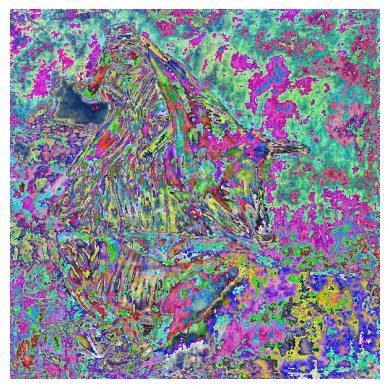

In [29]:
# Display output image
output_img = input_img.clone().detach().cpu().squeeze(0)
output_img = transforms.ToPILImage()(output_img)
plt.imshow(output_img)
plt.axis('off')
plt.show()

In [30]:
output_img.save('output_image.jpg')